# Importation des données

In [1]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#PCA & TSNE : 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

In [2]:
nb_tweets = 10000

os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')

with open("data/corpus_trie.file", "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

1344097

On ne garde ici que les {{nb_tweets}} premiers tweets

In [3]:
phrases = ens_tweets[0:nb_tweets]
words = [item for sublist in phrases for item in sublist]
print(type(words))
vocabulary = list(dict.fromkeys(words))
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))
fdist = nltk.FreqDist(words)

<class 'list'>
Nombre de mots : 110348
Taille du vocabulaire : 11377


In [4]:
with open('data/%ik/input.file' % int(nb_tweets/1000), "rb") as f:
    input = pickle.load(f)
with open('data/%ik/output.file' % int(nb_tweets/1000), "rb") as f:
    output = pickle.load(f)
mat_finale = (input+output)/2

# 1. Similarité cosinus
Pour tester la similarité entre deux mots, on calcule la similarité cosinus entre leur représentation vectorielle :
$$
\frac{A \cdot B}{|| A || \cdot || B ||}
$$

In [5]:
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}

def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))
def mot_plus_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]
print(fdist.most_common(100))

[('nickname', 7918), ('de', 4002), ('le', 2589), ('est', 2176), ('je', 2052), ('les', 1827), ('j', 1809), ('à', 1743), ('c', 1714), ('la', 1643), ('pas', 1605), ('que', 1271), ('en', 1180), ('a', 1063), ('et', 1061), ('un', 1028), ('ai', 935), ('ça', 892), ('il', 874), ('l', 831), ('mais', 769), ('pour', 743), ('😂', 743), ('d', 711), ('on', 705), ('une', 704), ('me', 689), ('tu', 676), ('ce', 584), ('qui', 551), ('dans', 536), ('t', 527), ('😭', 504), ('mon', 497), ('suis', 490), ('plus', 469), ('sur', 450), ('y', 446), ('moi', 437), ('qu', 422), ('bien', 408), ('fait', 387), ('ma', 357), ('si', 351), ('trop', 351), ('avec', 339), ('tout', 329), ('vous', 327), ('même', 318), ('bon', 314), ('m', 298), ('va', 295), ('faire', 291), ('toi', 282), ('elle', 280), ('ne', 271), ('mdr', 254), ('aussi', 249), ('comme', 247), ('merci', 246), ('oui', 246), ('️', 244), ('non', 240), ('se', 236), ('quand', 236), ('n', 236), ('vais', 236), ('ils', 233), ('là', 223), ('quoi', 204), ('être', 203), ('bon

In [6]:
mots = ["tweet", "bonjour", "wesh", "gros", "grosse", "femme"]
for mot in mots:
    if mot in mot_index:
        print('Pour le mot "%s"' %mot + " (%i apparitions), les mots les plus proches sont : " %fdist[mot])
        print(mot_plus_proche(mot))
        print("\n")

Pour le mot "tweet" (39 apparitions), les mots les plus proches sont : 
[('pigeon', 0.7410821513635363), ('jdormais', 0.731860940441796), ('brancher', 0.6917284161393576), ('🎃', 0.6819774503583397), ('wlh', 0.6652353949732815), ('reve', 0.6617998843375781), ('jeudis', 0.6562432317906416), ('messes', 0.6561506700488817), ('virtuelle', 0.655429782817181), ('auras', 0.6472892817656659)]


Pour le mot "bonjour" (118 apparitions), les mots les plus proches sont : 
[('durag', 0.7263516749587918), ('très', 0.7235954030194373), ('réveille', 0.6729981425558091), ('bizarrement', 0.6703559330727139), ('revois', 0.6282995954383115), ('glissante', 0.618134023995132), ('sayé', 0.6173920287683301), ('mcfly', 0.6036190621970643), ('planètes', 0.6034010770776302), ('classique', 0.6030713404103949)]


Pour le mot "wesh" (9 apparitions), les mots les plus proches sont : 
[('sandrine', 0.7227989253547985), ('relous', 0.7094025504762955), ('perspectives', 0.677234601243337), ('influence', 0.664485146066510

# 2. Evaluation par le "human judgement"

In [7]:
from scipy.stats import spearmanr
df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
df

,word1,word2,corr
0,corde,sourire,0.00
1,midi,ficelle,0.00
2,coq,périple,0.06
3,fruit,fournaise,0.11
4,autographe,rivage,0.00
...,...,...,...
60,coussin,oreiller,3.00
61,cimetière,cimetière,4.00
62,automobile,auto,3.94
63,joyau,bijou,3.22


In [8]:
def distance_mots(word1,word2):
    if word1 in mot_poids.keys() and word2 in mot_poids.keys():
        word_distance = (cos_distance(mot_poids[word1],(mot_poids[word2])))
    else:
        word_distance = float('nan')
    return word_distance
distance_mots_v = np.vectorize(distance_mots)
df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"])
print(len(df))
df = df.dropna()
print(len(df))
df

65
7


,word1,word2,corr,corr_word2vec
20,garçon,sage,0.29,-0.363641
33,auto,voyage,0.33,-0.061779
35,verre,bijou,0.56,0.249542
38,frère,gars,2.00,-0.482883
53,voyage,périple,2.59,0.146896
59,garçon,gars,3.83,0.338880
64,midi,dîner,2.17,0.623344


In [9]:
#On fait des tests à 5 %
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
if p_value > alpha:
    print('Le résultat de word2vec est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

Le résultat de word2vec est différent de celui du human judgement (non rejet de H0 = non corrélation) p=0.180 / Valeur de la corrélation : 0.571


# 3. PCA

In [23]:
def ACP(liste, statique = True, nom_couples_explicite=True):
    # On enlève les mots qui n'existent pas
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index]) 
    liste_mots = [w for couple in liste_triee for w in couple]

    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i        

    features = list(range(0, len(liste_triee)))
    # Separating out the features
    x = df_res.loc[:, features].values
    # Separating out the target
    y = df_res.loc[:,['label']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['Axe 1', 'Axe 2'])

    df_res['mot'] = df_res.index.values
    df_res = df_res.reset_index()

    finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)

    if statique:
        # Représentation simple statique 
        fig = plt.figure(figsize = (12,8))

        g = sns.scatterplot(x="Axe 1", y="Axe 2",
                        hue="label", data=finalDf, s = 150)
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(finalDf["label"])))
    else:
        init_notebook_mode(connected=True)

        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        #subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)
        subFinalDf = pd.concat([finalDf],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='Axe 1',
                      y='Axe 2',
                      categories='label',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='ACP en 2 composantes',
                      filename='cufflinks/simple-scatter')


In [24]:
liste = [["homme","femme", "enfant"],["chien","chat"],
         ["vanille","chocolat"],
    ["poli","courtois"],["bonjour","salut"],["propre","sale"],["canapé","fauteuil"],
    ["téléphone","portable"],["voiture","camion"],["grand","petit"]]

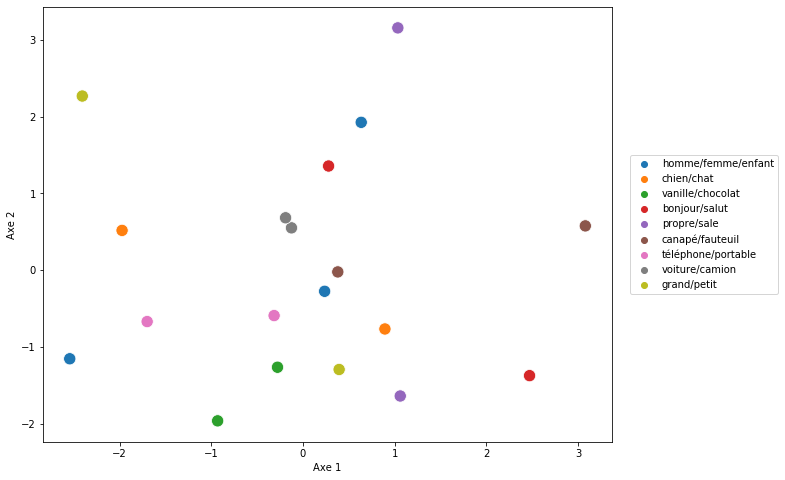

In [25]:
ACP(liste, statique = True)

In [26]:
ACP(liste, statique = False)

# 4. TSNE

In [220]:
def tsne_graph(liste, statique = True, nom_couples_explicite=True):
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index])
    liste_mots = [w for couple in liste_triee for w in couple]
    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i  
    features = list(range(0, len(liste)))
    # Separating out the features
    data_x = df_res.loc[:, features].values
    # Separating out the target
    data_y = df_res.loc[:,['label']].values

    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(data_x)

    test_features = [[i+1]*len(liste_triee[i]) for i in range(0, len(liste_triee))]
    test_features = [i for f in test_features for i in f]
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                            'Y':tsne_obj[:,1],
                           'digit':test_features})
    tsne_df["legend"] = tsne_df["digit"]
    for i in range(0,len(tsne_df)):
        tsne_df["legend"][i]= "Couple %i" %tsne_df["digit"][i]
    if statique:
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="X", y="Y",
                            hue = "legend",
                            data=tsne_df);
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(tsne_df["legend"])))
    else:
        tsne_df["mot"] = liste_mots
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        subFinalDf = pd.concat([tsne_df],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='X',
                      y='Y',
                      categories='legend',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='TSNE',
                      filename='cufflinks/simple-scatter')
        

In [228]:
liste = [["homme", "tttttttttt","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
]

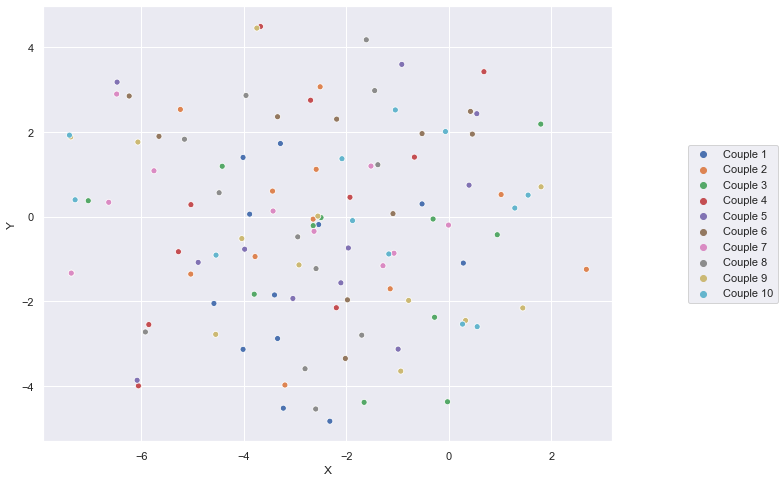

In [229]:
tsne_graph(liste, statique = True,
           nom_couples_explicite = False)

In [226]:
tsne_graph(liste, statique = False,
           nom_couples_explicite = False)

In [240]:
print(set(["g","a","a","c","d","e","z"]))
print(set(["g","a","a","c","d","e","z"]))
print(set(["g","a","a","c","d","e","z"]))
print(set(["g","a","a","c","d","e","z"]))

{'a', 'd', 'g', 'e', 'c', 'z'}
{'a', 'd', 'g', 'e', 'c', 'z'}
{'a', 'd', 'g', 'e', 'c', 'z'}
{'a', 'd', 'g', 'e', 'c', 'z'}


In [254]:
import subprocess
subprocess.run(["python --version"])

FileNotFoundError: [Errno 2] No such file or directory: 'python --version': 'python --version'